(quickstart)=

# Quickstart

## Keplerian system

In `jaxoplanet`, a Keplerian system can be instantiated with a [Central](jaxoplanet.orbits.keplerian.Central) object

In [1]:
from jaxoplanet.orbits.keplerian import System, Central

system = System(Central())  # a central object with some default parameters

and add an orbiting [Body](jaxoplanet.orbits.keplerian.Body) 

In [2]:
system = system.add_body(period=0.1)

As many arguments are optional, it's always a good idea to check the parameters of the system.

In [3]:
system

System(
  central=Central(
    mass=<Quantity(1.0, 'M_sun')>,
    radius=<Quantity(1.0, 'R_sun')>,
    density=<Quantity(0.238732415, 'M_sun / R_sun ** 3')>
  ),
  _body_stack=ObjectStack(...)
)

For the reminder of this notebook, let's define a system consisting of an Earth-like planet orbiting a Sun-like star.

In [4]:
from jaxoplanet.units import unit_registry as ureg

sun = Central(
    radius=1.0 * ureg.R_sun,
    mass=1.0 * ureg.M_sun,
)

system = System(sun).add_body(
    semimajor=1.0 * ureg.au,
    radius=1.0 * ureg.R_earth,
    mass=1.0 * ureg.M_earth,
)

earth = system.bodies[0]

# checking the parameters of the system
system

System(
  central=Central(
    mass=<Quantity(1.0, 'M_sun')>,
    radius=<Quantity(1.0, 'R_sun')>,
    density=<Quantity(0.238732415, 'M_sun / R_sun ** 3')>
  ),
  _body_stack=ObjectStack(...)
)

```{note}

Notice the use of the [jaxoplanet.units](jaxoplanet.units) module to handle physical units. Check *TODO* for an introduction to the unit system used by `jaxoplanet`.

```

## Radial velocity

Then, one can access the relative position and velocity of the planet relative to the sun. 

In [5]:
import jax.numpy as jnp
from matplotlib import pyplot as plt

# Get the position of the planet and velocity of the star as a function of time
t = jnp.linspace(0, 730, 5000)
x, y, z = earth.relative_position(t)
vx, vy, vz = earth.central_velocity(t)

```{note}
Axes and orbital parameters conventions follow that of the [*exoplanet* package](https://docs.exoplanet.codes/en/latest/tutorials/data-and-models/).
```

And plot the results

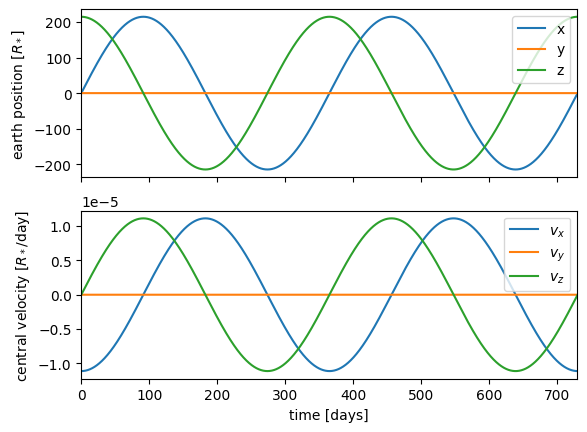

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(t, x.magnitude, label="x")
ax.plot(t, y.magnitude, label="y")
ax.plot(t, z.magnitude, label="z")
ax.set_ylabel("earth position [$R_*$]")
ax.legend(fontsize=10, loc=1)

ax = axes[1]
ax.plot(t, vx.magnitude, label="$v_x$")
ax.plot(t, vy.magnitude, label="$v_y$")
ax.plot(t, vz.magnitude, label="$v_z$")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("central velocity [$R_*$/day]")
_ = ax.legend(fontsize=10, loc=1)

## Occultation light curve of limb-darkened star

`jaxoplanet` contains module to compute occultation light curves of stars given different photosphere properties. For example, we can define a limb-darkened [light_curve](jaxoplanet.light_curves.limb_dark.light_curve) to compute the flux of a star with a polynomial limb darkening, allowing to express linear, quadratic and more complex laws.

Using the limb-darkening coefficients from [Hestroffer and Magnan](https://www.physics.hmc.edu/faculty/esin/a101/limbdarkening.pdf) we compute the flux

In [7]:
from jaxoplanet.light_curves.limb_dark import light_curve

u = (0.30505, 1.13123, -0.78604, 0.40560, 0.02297, -0.07880)
time = jnp.linspace(-0.5, 0.5, 1000)

flux = 1.0 + light_curve(system, u)(time)

and plot the resulting light curve

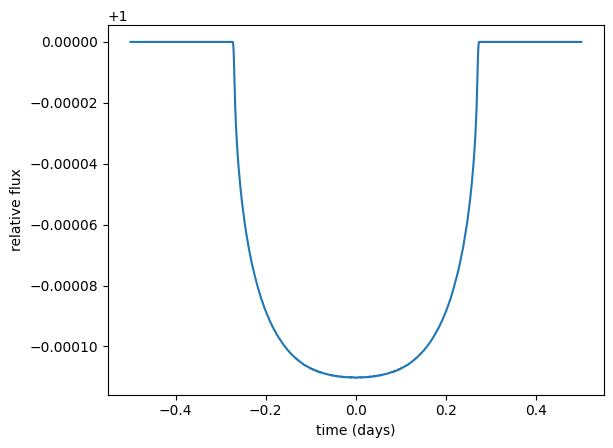

In [8]:
plt.plot(time, flux)
plt.xlabel("time (days)")
_ = plt.ylabel("relative flux")

## Non-uniform stars

`jaxoplanet` aims to match the features of [starry](https://github.com/rodluger/starry), a framework to compute the light curves of systems made of non-uniform spherical bodies.

```{warning}
While being stable, computing *starry* light curves of non-uniform surfaces is still an experimental part of `jaxoplanet`.
```

Let's define a [Surface](jaxoplanet.experimental.starry.surface.Surface) in the [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics) basis (using the [Ylm](jaxoplanet.experimental.starry.ylm.Ylm) object) and visualize it


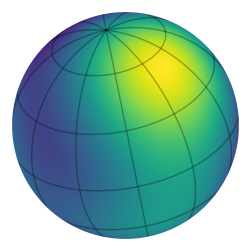

In [10]:
import numpy as np
from jaxoplanet.starry.ylm import Ylm
from jaxoplanet.starry.surface import Surface
from jaxoplanet.starry.visualization import show_surface

np.random.seed(42)
y = Ylm.from_dense([1.00, *np.random.normal(0.0, 2e-2, size=15)])

u = (0.1, 0.1)
surface = Surface(inc=1.0, obl=0.2, period=27.0, u=u, y=y)

plt.figure(figsize=(3, 3))
show_surface(surface)

### Rotational light curves

We can attach this surface to a body (like the sun-like object we previously defined) and define a [SurfaceSystem](jaxoplanet.experimental.starry.orbit.SurfaceSystem)

In [11]:
from jaxoplanet.starry.orbit import SurfaceSystem

system = SurfaceSystem(sun, surface)

and compute the rotational light curve of the star

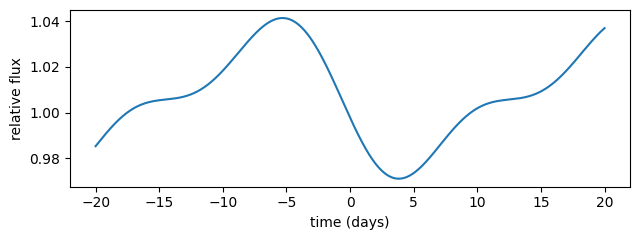

In [13]:
from jaxoplanet.starry.light_curves import light_curve

plt.figure(figsize=(6.5, 2.5))
time = jnp.linspace(-20, 20, 1000)
flux = light_curve(system)(time).T[0]

plt.plot(time, flux)
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.tight_layout()

### Occultation light curve

We can add a body to the system, itself optionally having a surface

In [14]:
system = SurfaceSystem(sun, surface)

secondary_surface = Surface(
    y=Ylm.from_dense([1.00, *np.random.normal(0.0, 1.0, size=15)])
)

system = system.add_body(
    semimajor=40.0 * ureg.au,
    radius=20.0 * ureg.R_earth,
    mass=1.0 * ureg.M_earth,
    impact_param=0.2,
    surface=secondary_surface,
)

And compute the occultation light curve of the system

In [15]:
t_start, t_end = -20, 20
n = 1000
time = jnp.linspace(t_start, t_end, n)
flux = light_curve(system)(time).T[0]

Let's plot it and show the system in time

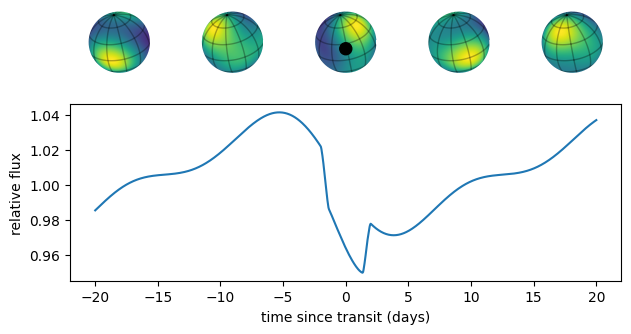

In [16]:
n_plots = 5
times = jnp.linspace(t_start, t_end, n_plots)
radius_ratio = (system.bodies[0].radius / system.central.radius).magnitude
gs = plt.GridSpec(2, n_plots)

plt.figure(figsize=(6.5, 4.0))

for i in range(n_plots):
    ax = plt.subplot(gs[0, i])
    phase = surface.rotational_phase(times[i])
    x, y = system.bodies[0].position(times[i])[0:2]
    show_surface(surface, ax=ax, theta=phase)
    circle = plt.Circle(
        (x.magnitude, y.magnitude), radius_ratio, color="k", fill=True, zorder=10
    )
    ax.add_artist(circle)
    ax.set_xlim(-1.5, 1.5)

plt.subplot(gs[1, :])
plt.plot(time, flux)

plt.xlabel("time since transit (days)")
plt.ylabel("relative flux")
plt.tight_layout()